In [1]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem, DataStructs

# Helper Functions

In [2]:
# helper function for processing data
def process(df, method, cpd, good_cols = ['SMILES', 'ACTIVITY'], smiles_col = 'SMILES', hit_col = 'hit'):
    df = df[[smiles_col, hit_col]]
    df.columns = good_cols
    df['Method'] = [method] * len(df)
    df['Cpd'] = [cpd] * len(df)
    print('# of ' + cpd + ' molecules generated by ' + method + ': ' + str(len(df)))
    return(df)

In [3]:
# helper function for downselection algorithm
def for_mol_list_get_highest_tanimoto_to_closest_mol(cpd_mols, molecules_to_check):
    mols_fps = [Chem.RDKFingerprint(mo) for mo in cpd_mols]
    check_fps = [Chem.RDKFingerprint(mo) for mo in molecules_to_check]
    best_sims = []
    for m in mols_fps:
        if m is None:
            best_sims.append(-1)
        curr_highest_sim = 0
        for check in check_fps:
            sim = DataStructs.FingerprintSimilarity(m,check)
            if sim > curr_highest_sim: # optionally, could implement a thresholding here
                curr_highest_sim = sim
        best_sims.append(curr_highest_sim)
    return(best_sims)

def check_full_cpd_similarity_to_closest_selected_mols(smi_of_interest, selected_mols_df, df):
    if len(selected_mols_df) == 0:
        return([0] * len(df))
    mol = Chem.MolFromSmiles(smi_of_interest)
    selected_mols = [Chem.MolFromSmiles(smi) for smi in list(selected_mols_df['SMILES'])]
    tan_scores = for_mol_list_get_highest_tanimoto_to_closest_mol([mol], selected_mols)
    return(tan_scores)

def select_cpds_from_df(df, maximum, top_to_get, max_tan_allowed_after_top = 0.75):
    selected_mols_df = pd.DataFrame()
    df = df.sort_values('ACTIVITY', ascending = False).reset_index(drop = True)
    for i, row in df.iterrows():   
        if i < top_to_get:
            display(Chem.MolFromSmiles(row['SMILES']))
            print(i, row['Method'], row['ACTIVITY'])
            selected_mols_df = pd.concat([selected_mols_df, pd.DataFrame(row).T])
        else: 
            if len(selected_mols_df) >= maximum:
                print("*********REACHED END: SELECTED " + str(len(selected_mols_df)) + " MOLECULES*********")
                break
            else:
                smi_of_interest = row['SMILES']
                tan_to_selected_mols = check_full_cpd_similarity_to_closest_selected_mols(smi_of_interest, selected_mols_df, df)
                if tan_to_selected_mols[0] >= max_tan_allowed_after_top:
                    continue
                else:
                    # SELECTION
                    display(Chem.MolFromSmiles(row['SMILES']))
                    print(i, row['Method'], row['ACTIVITY'])
                    selected_mols_df = pd.concat([selected_mols_df, pd.DataFrame(row).T])
    return(selected_mols_df)

# Load in CReM and VAE compounds

In [4]:
# first grab crem compounds
ng_crem = pd.read_csv('../out/crem/ng_crem/final_crem_ngcpd_downselected_mols.csv')
ng_crem = process(ng_crem, 'CReM', 'NG_Cpd')

v027_crem = pd.read_csv('../out/crem/v027_crem/final_crem_v027_downselected_mols.csv')
v027_crem = process(v027_crem, 'CReM', 'V027', hit_col = 'ACTIVITY')

# of NG_Cpd molecules generated by CReM: 285
# of V027 molecules generated by CReM: 428


In [5]:
# now vae cpds
# gonorrhea has 679 compounds with a chemprop score > 0.8, toxicity < 0.2, and RAscore > 0.8.
ng_vae = pd.read_csv('../out/crem/vae_candidates/ngcpd_vae_final_mols.csv')
ng_vae = ng_vae[ng_vae['ACTIVITY'] > 0.8]
ng_vae = ng_vae[ng_vae['TOXICITY'] < 0.2]
ng_vae = ng_vae[ng_vae['RAscore'] > 0.8]
# if we preprocess vae molecules - calculate PRIMARY toxicity in addition to HepG2 tox, etc. - on GCP, we get below df
ng_vae = process(ng_vae, 'VAE', 'NG_Cpd', smiles_col = 'smiles', hit_col = 'ACTIVITY')

# v027 cpds using the real fragment - V027 tab uses the fragment suggested by algorithm. It doesn't have any compounds with a chemprop score > 0.5. There are 44 compounds with chemprop score > 0.4, toxicity < 0.2, and RAscore > 0.9 (I needed to raise the threshold because there are some weird compounds with RA score 0.8ish).
v027_vae = pd.read_excel('../out/crem/vae_candidates/v027_vae_fragment_generation.xlsx', sheet_name = 'V027')
v027_vae = v027_vae[v027_vae['ACTIVITY'] > 0.4]
v027_vae = v027_vae[v027_vae['TOXICITY'] < 0.2]
v027_vae = v027_vae[v027_vae['RAscore'] > 0.9]
v027_vae = process(v027_vae, 'VAE', 'V027', smiles_col = 'smiles', hit_col = 'ACTIVITY')

# V027 MCS means using the maximum common substructure of V027 series drugs (with two additional chlorines) as the fragment. This somehow helped. I got 124 compounds with chemprop score > 0.5, toxicity < 0.2, and RAscore > 0.9. 
v027mcs_vae = pd.read_excel('../out/crem/vae_candidates/v027_vae_fragment_generation.xlsx', sheet_name = 'V027-MCS')
v027mcs_vae = v027mcs_vae[v027mcs_vae['ACTIVITY'] > 0.5]
v027mcs_vae = v027mcs_vae[v027mcs_vae['RAscore'] > 0.9]
v027mcs_vae = process(v027mcs_vae, 'VAE', 'V027', smiles_col = 'smiles', hit_col = 'ACTIVITY')

# of NG_Cpd molecules generated by VAE: 159
# of V027 molecules generated by VAE: 43
# of V027 molecules generated by VAE: 124


# Priority Downselection

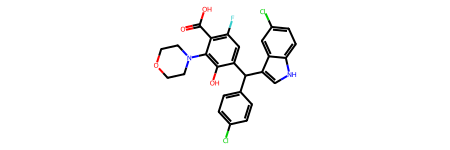

0 VAE 0.558705735206604


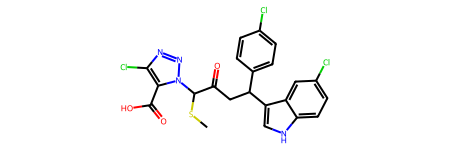

1 VAE 0.551632116734981


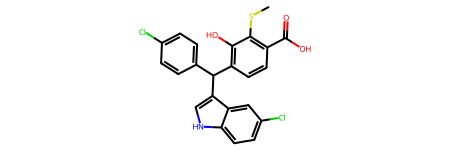

2 VAE 0.535047306865453


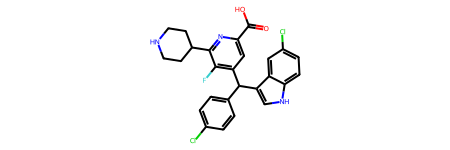

3 VAE 0.534377588331699


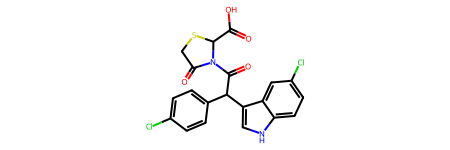

4 VAE 0.534188318252563


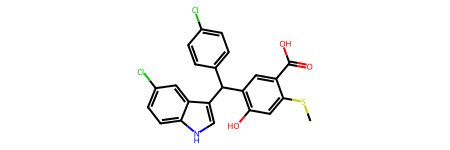

5 VAE 0.533672441542148


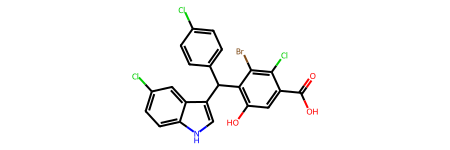

6 VAE 0.532444567978382


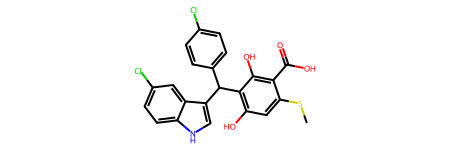

7 VAE 0.530964496731758


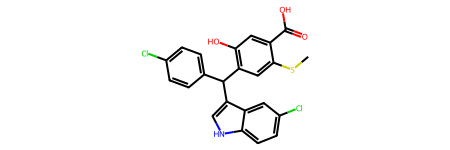

8 VAE 0.530153723806142


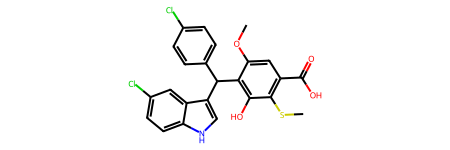

9 VAE 0.530067849904298


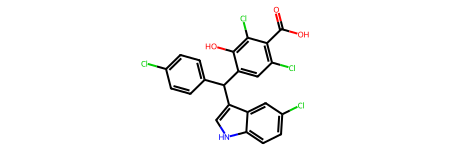

10 VAE 0.529643858224153


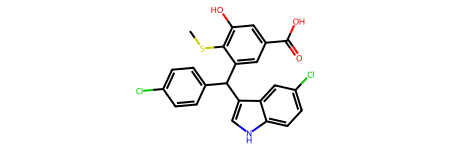

11 VAE 0.527543909847736


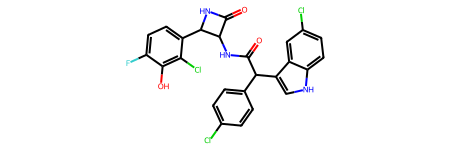

12 VAE 0.526424884796142


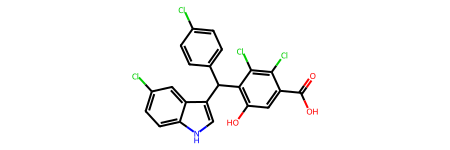

13 VAE 0.526340460777282


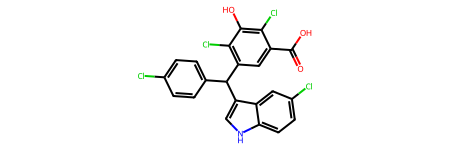

14 VAE 0.5256002523005


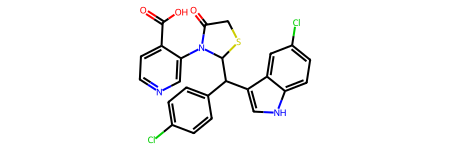

15 VAE 0.524129645526409


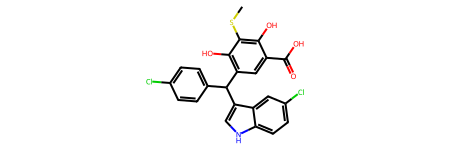

16 VAE 0.523957192897796


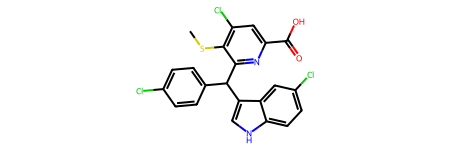

17 VAE 0.523826533555984


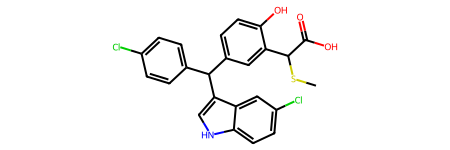

18 VAE 0.523261059820652


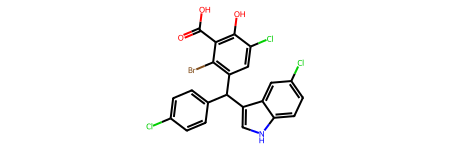

19 VAE 0.521395485848188


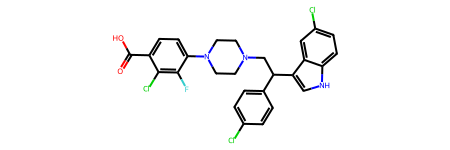

21 VAE 0.521052703261375


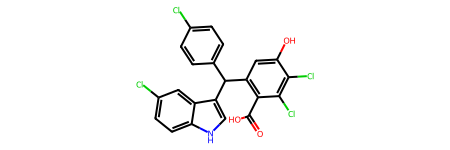

22 VAE 0.520743662118911


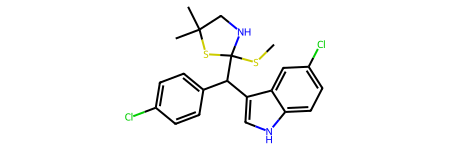

26 VAE 0.518370288610458


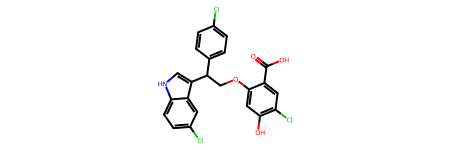

27 VAE 0.517123913764953


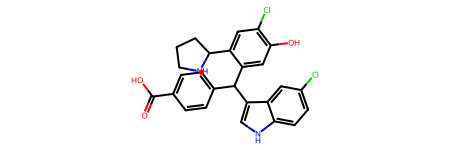

29 VAE 0.517037330567836


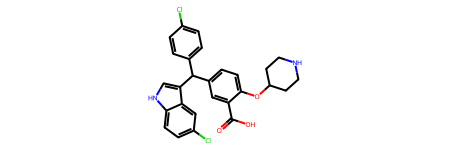

30 VAE 0.516639804840087


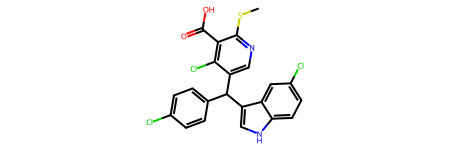

31 VAE 0.516464745998382


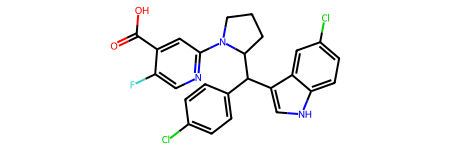

33 VAE 0.51408371925354


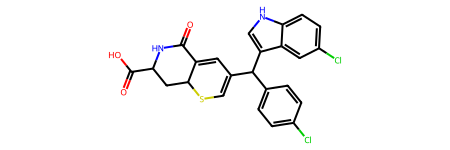

36 VAE 0.513358560204505


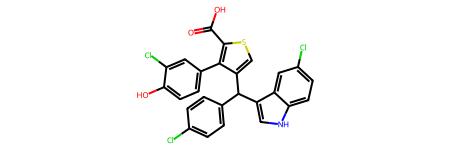

37 VAE 0.513252959400415


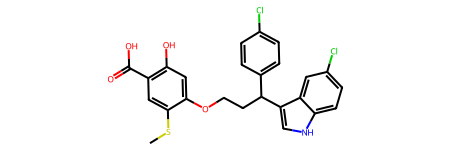

39 VAE 0.512854094803333


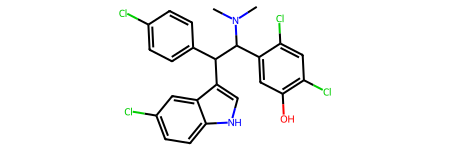

40 VAE 0.512850848585367


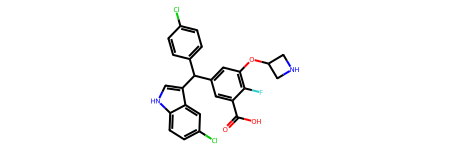

41 VAE 0.511903513222932


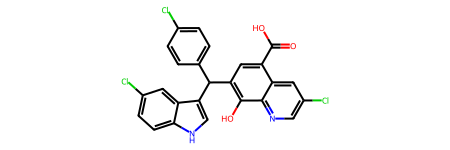

42 VAE 0.51174377053976


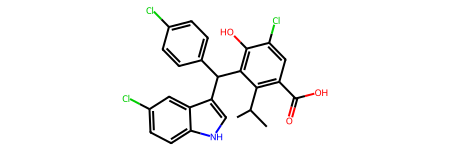

45 VAE 0.511234214156866


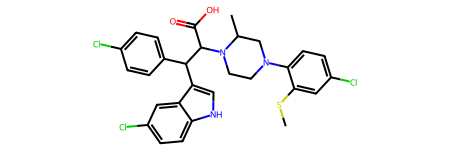

46 VAE 0.51109444797039


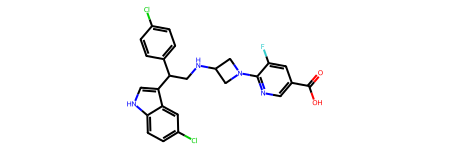

51 VAE 0.510212455689907


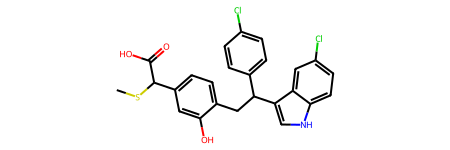

52 VAE 0.510154604911804


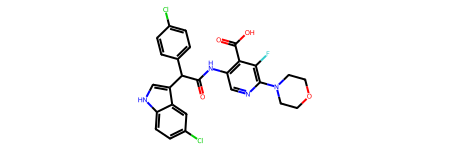

53 VAE 0.509922984242439


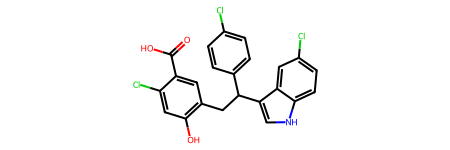

57 VAE 0.509419670701026
*********REACHED END: SELECTED 40 MOLECULES*********


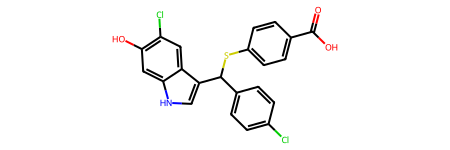

0 CReM 0.5144681930541992


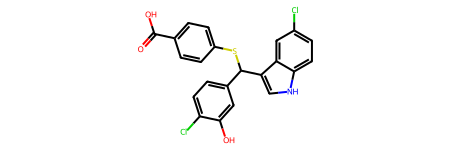

1 CReM 0.5124633640050889


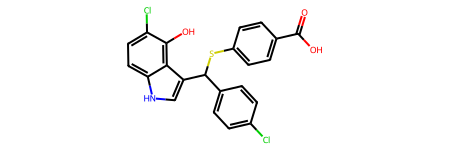

2 CReM 0.5105138048529625


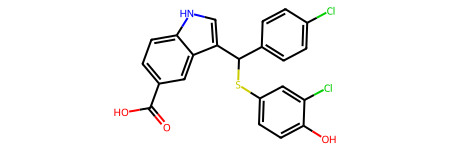

3 CReM 0.5003972575068474


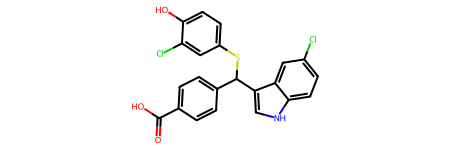

4 CReM 0.5001387745141983


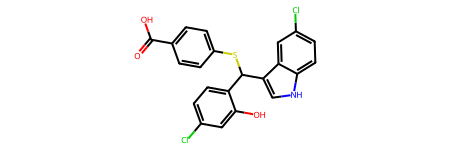

5 CReM 0.4979168727993965


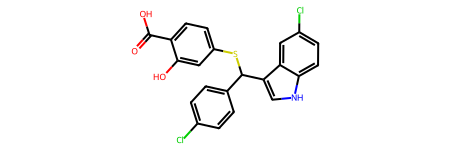

6 CReM 0.4921446457505226


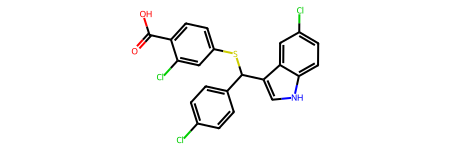

7 CReM 0.4914099261164665


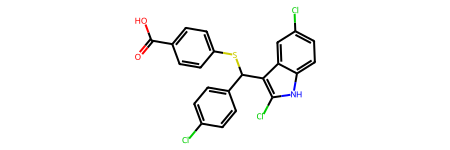

8 CReM 0.488184218108654


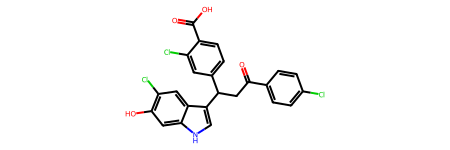

9 CReM 0.4842649102210998


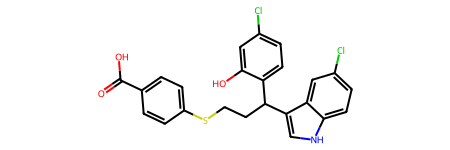

10 CReM 0.4822133347392082


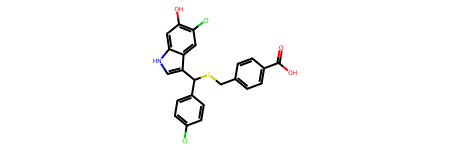

11 CReM 0.48190348893404


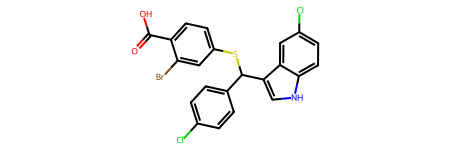

12 CReM 0.4817797109484673


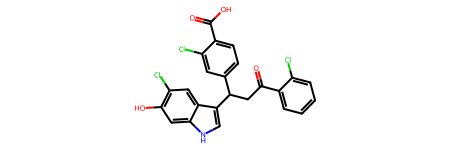

13 CReM 0.4813266284763813


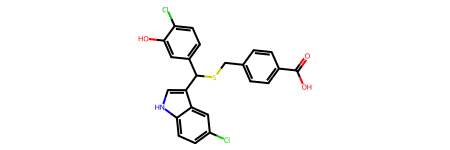

14 CReM 0.4773969247937202


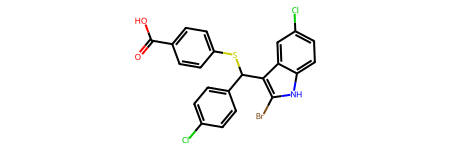

15 CReM 0.4749686256051063


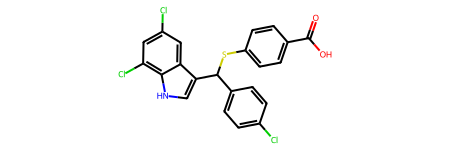

16 CReM 0.474565652012825


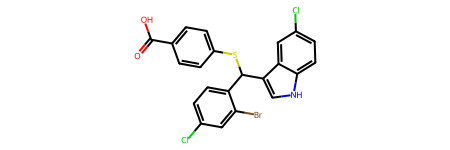

17 CReM 0.471616142988205


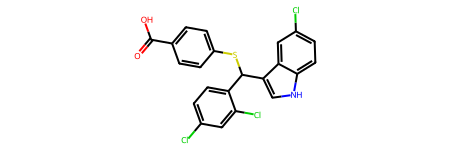

18 CReM 0.467656510323286


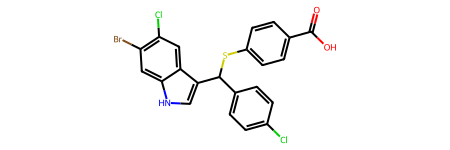

19 CReM 0.4663277804851532


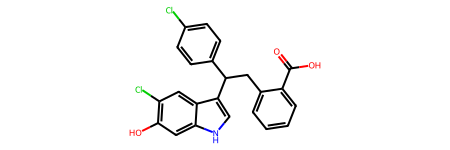

23 CReM 0.4614881224930286


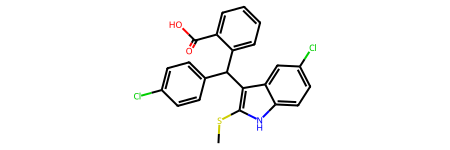

35 CReM 0.4524300441145897


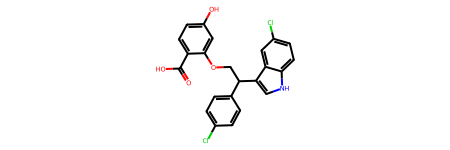

38 CReM 0.4484141610562801


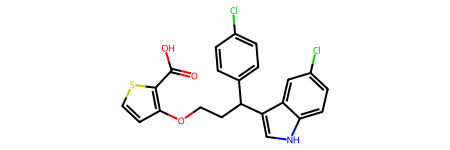

43 CReM 0.4382417999207973


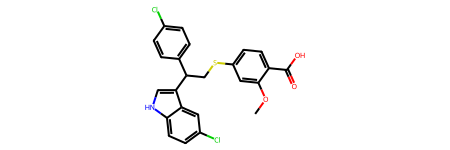

58 CReM 0.432570193707943


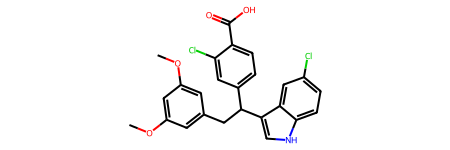

64 CReM 0.4273700959980487


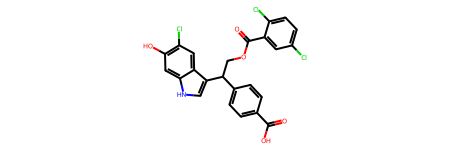

66 CReM 0.4261044599115848


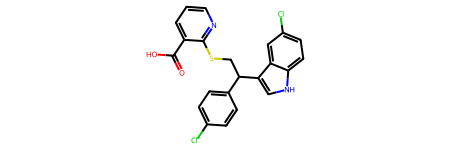

71 CReM 0.4225370928645134


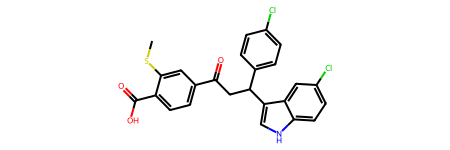

74 CReM 0.4190410181879997


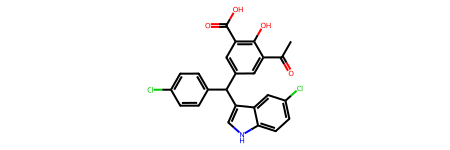

93 CReM 0.4077962875366211


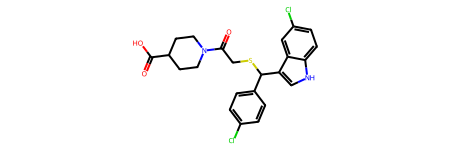

99 CReM 0.4047937095165252


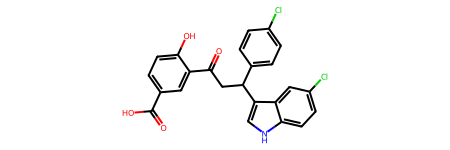

101 CReM 0.4039613835513592


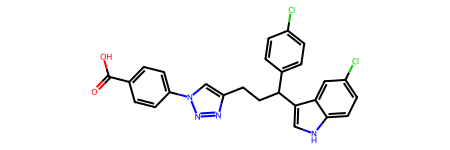

109 CReM 0.3979195557534695


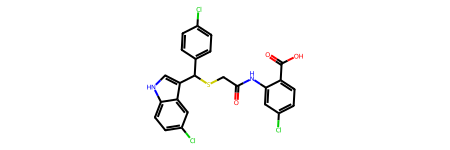

118 CReM 0.3949400886893272


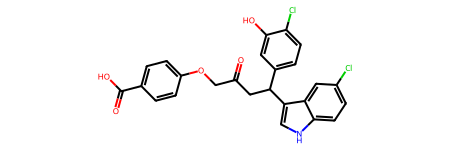

122 CReM 0.3939831100404262


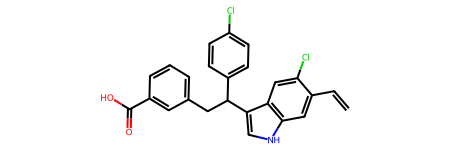

130 CReM 0.3925950616598129


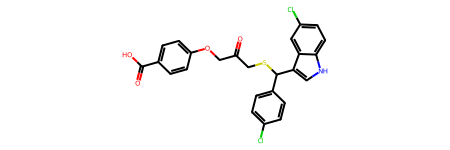

132 CReM 0.3925378732383251


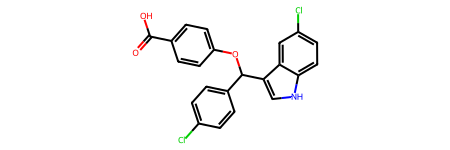

139 CReM 0.3903191439807415


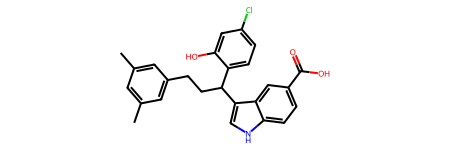

145 CReM 0.3864183343946933


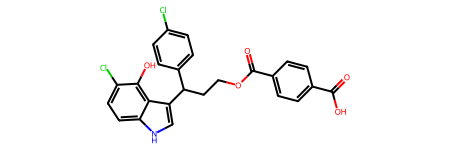

149 CReM 0.3854750856757164
*********REACHED END: SELECTED 40 MOLECULES*********
combined crem and vae: 80


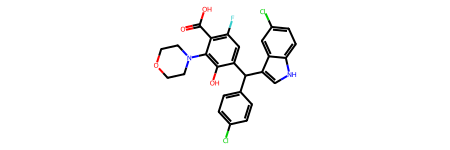

0 VAE 0.558705735206604


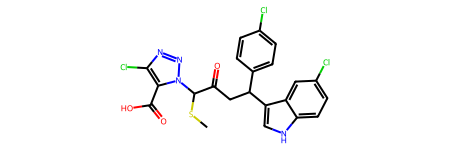

1 VAE 0.551632116734981


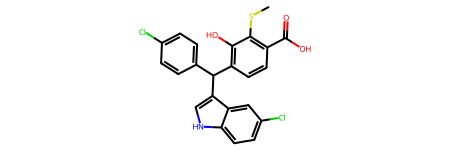

2 VAE 0.535047306865453


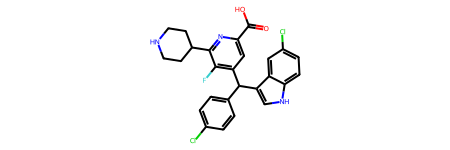

3 VAE 0.534377588331699


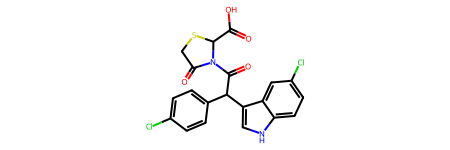

4 VAE 0.534188318252563


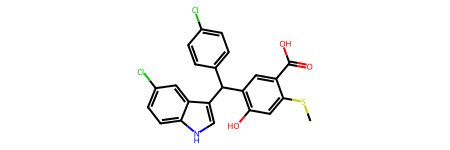

5 VAE 0.533672441542148


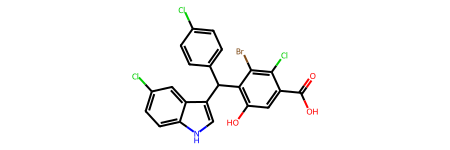

6 VAE 0.532444567978382


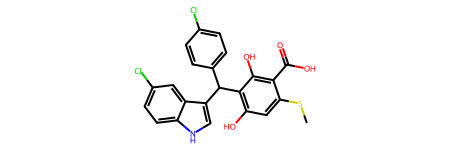

7 VAE 0.530964496731758


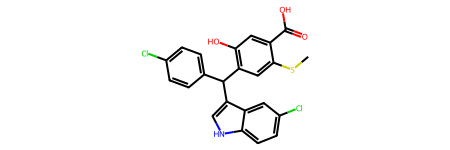

8 VAE 0.530153723806142


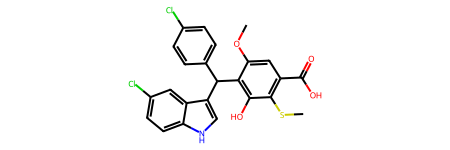

9 VAE 0.530067849904298


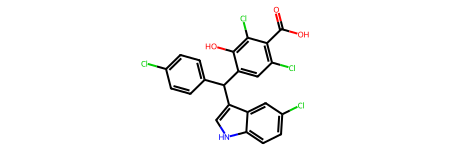

10 VAE 0.529643858224153


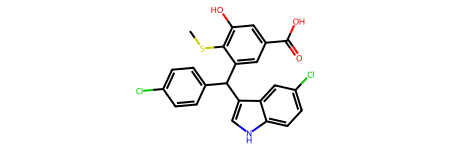

11 VAE 0.527543909847736


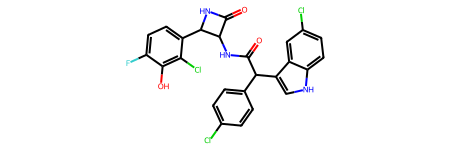

12 VAE 0.526424884796142


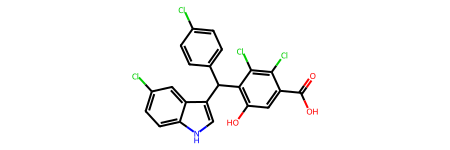

13 VAE 0.526340460777282


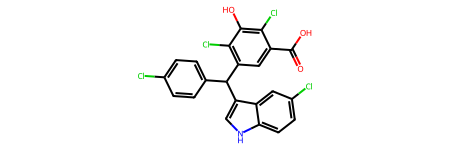

14 VAE 0.5256002523005


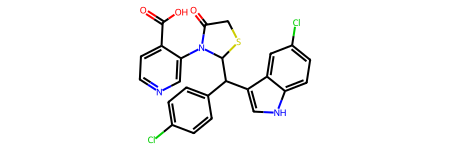

15 VAE 0.524129645526409


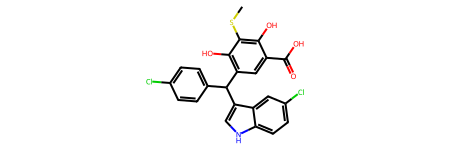

16 VAE 0.523957192897796


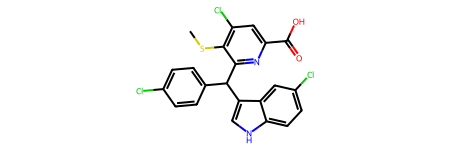

17 VAE 0.523826533555984


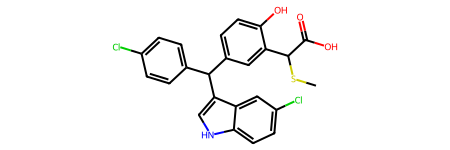

18 VAE 0.523261059820652


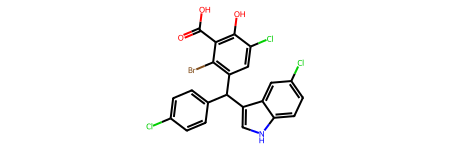

19 VAE 0.521395485848188


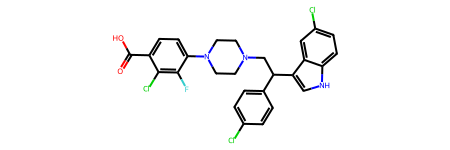

20 VAE 0.521052703261375


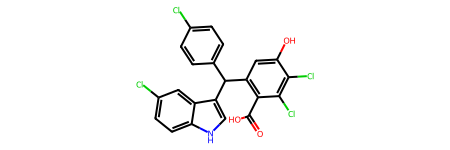

21 VAE 0.520743662118911


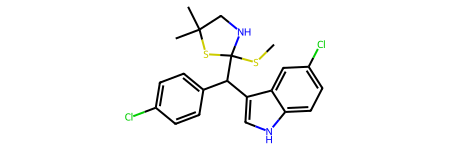

22 VAE 0.518370288610458


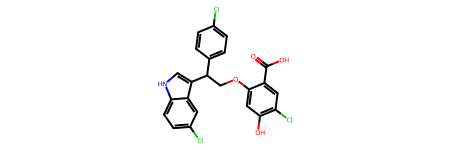

23 VAE 0.517123913764953


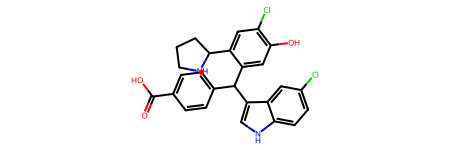

24 VAE 0.517037330567836


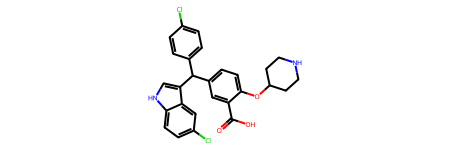

25 VAE 0.516639804840087


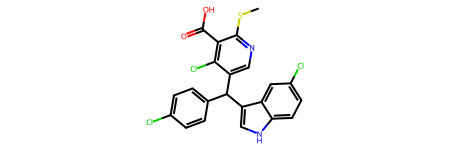

26 VAE 0.516464745998382


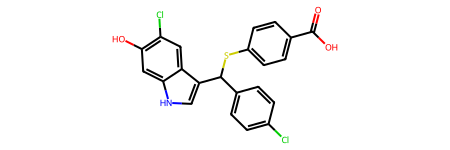

27 CReM 0.5144681930541992


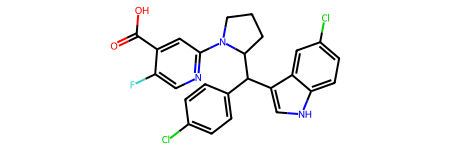

28 VAE 0.51408371925354


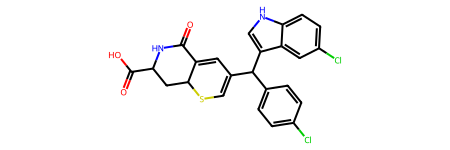

29 VAE 0.513358560204505


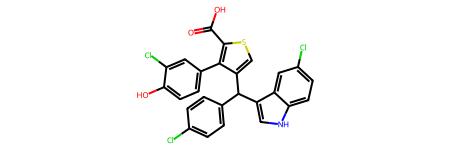

30 VAE 0.513252959400415


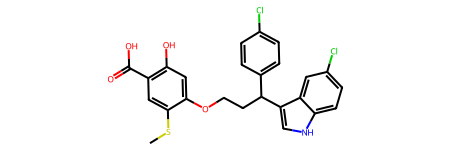

31 VAE 0.512854094803333


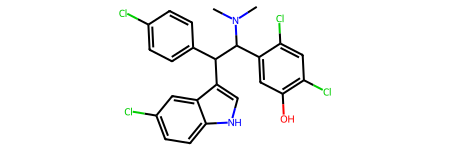

32 VAE 0.512850848585367


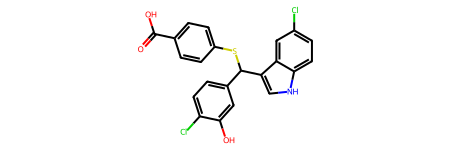

33 CReM 0.5124633640050889


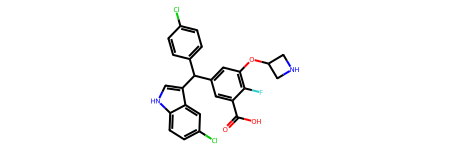

34 VAE 0.511903513222932


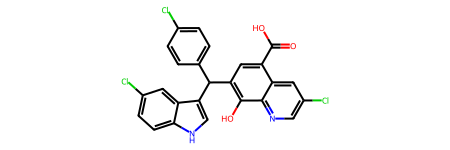

35 VAE 0.51174377053976


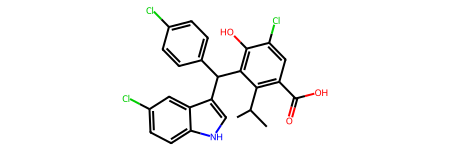

36 VAE 0.511234214156866


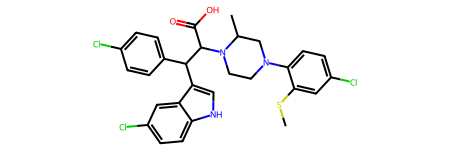

37 VAE 0.51109444797039


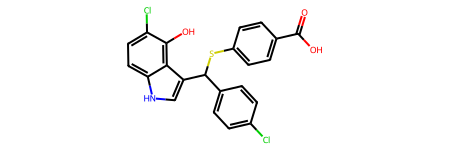

38 CReM 0.5105138048529625


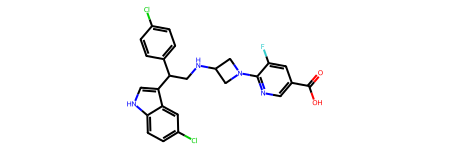

39 VAE 0.510212455689907


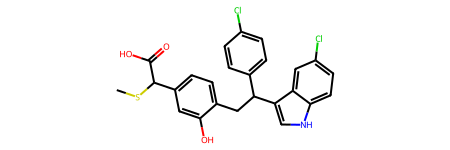

40 VAE 0.510154604911804


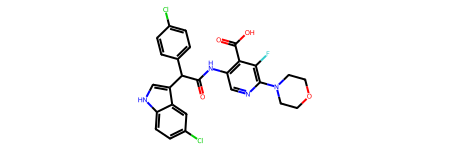

41 VAE 0.509922984242439


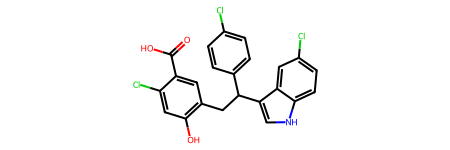

42 VAE 0.509419670701026


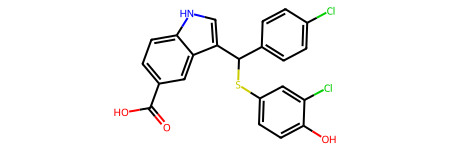

43 CReM 0.5003972575068474


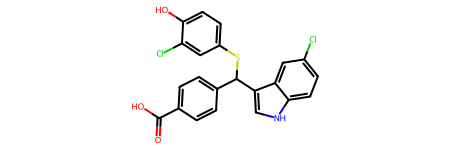

44 CReM 0.5001387745141983


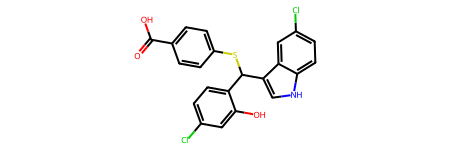

45 CReM 0.4979168727993965


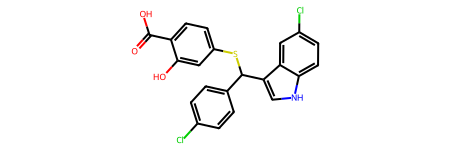

46 CReM 0.4921446457505226


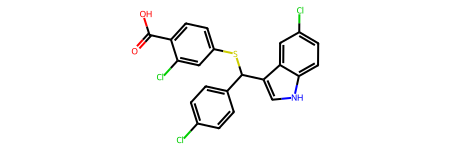

47 CReM 0.4914099261164665


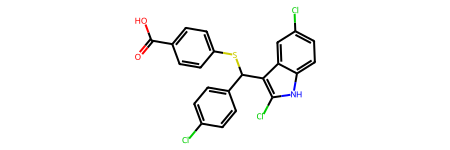

48 CReM 0.488184218108654


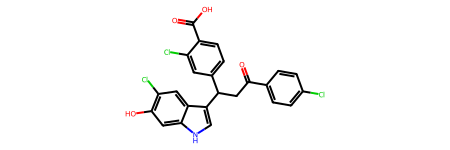

49 CReM 0.4842649102210998


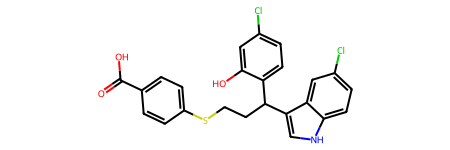

50 CReM 0.4822133347392082


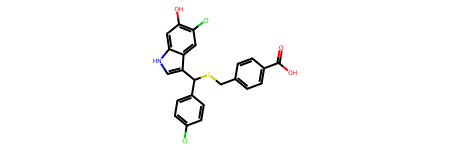

51 CReM 0.48190348893404


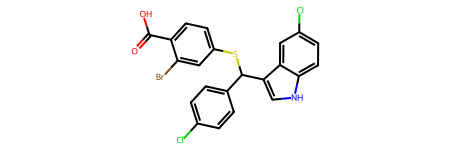

52 CReM 0.4817797109484673


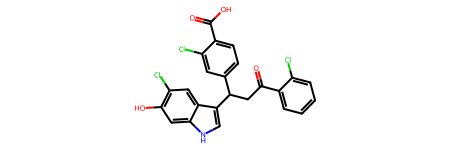

53 CReM 0.4813266284763813


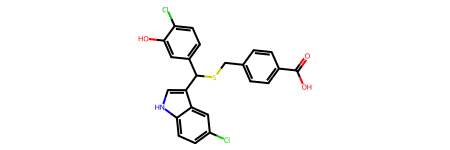

54 CReM 0.4773969247937202


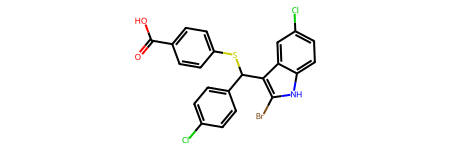

55 CReM 0.4749686256051063


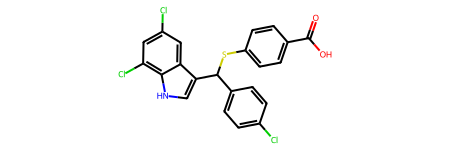

56 CReM 0.474565652012825


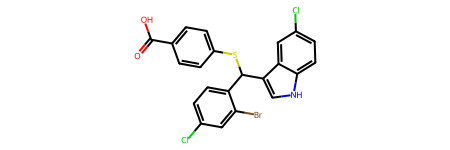

57 CReM 0.471616142988205


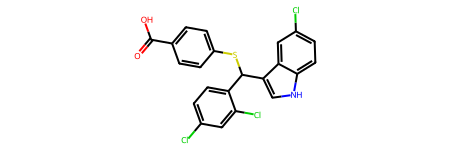

58 CReM 0.467656510323286


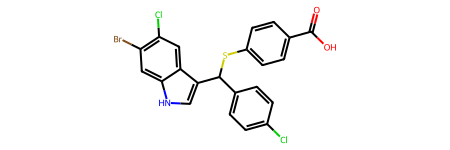

59 CReM 0.4663277804851532


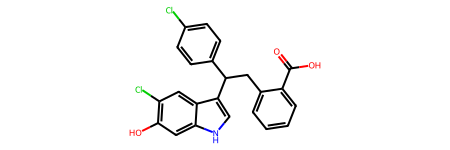

60 CReM 0.4614881224930286


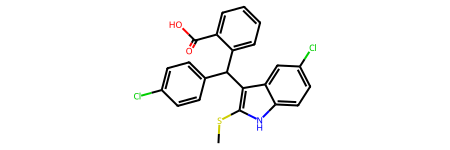

61 CReM 0.4524300441145897


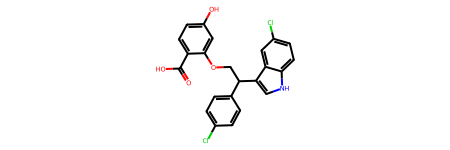

62 CReM 0.4484141610562801


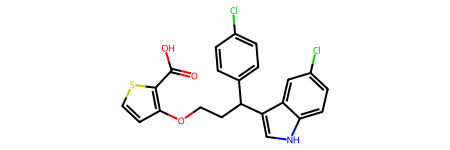

63 CReM 0.4382417999207973


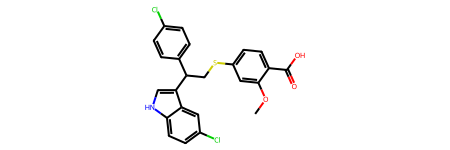

64 CReM 0.432570193707943


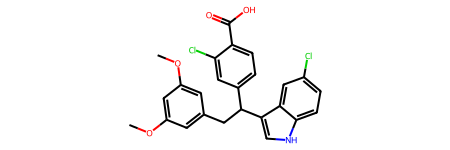

65 CReM 0.4273700959980487


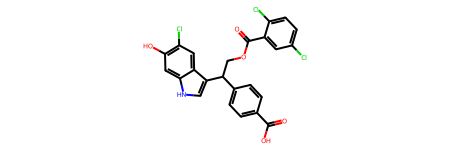

66 CReM 0.4261044599115848


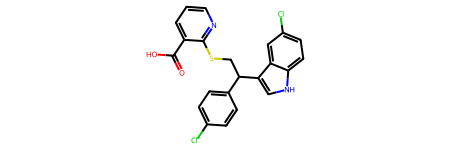

67 CReM 0.4225370928645134


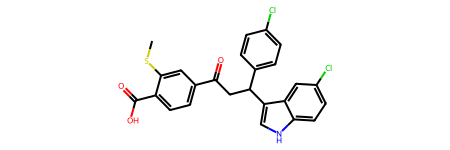

68 CReM 0.4190410181879997


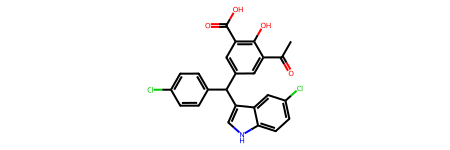

69 CReM 0.4077962875366211


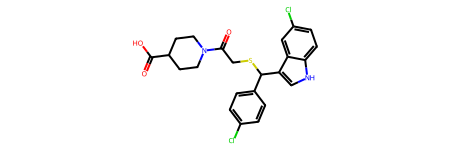

70 CReM 0.4047937095165252


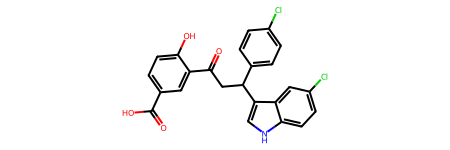

71 CReM 0.4039613835513592


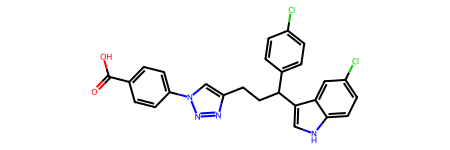

72 CReM 0.3979195557534695


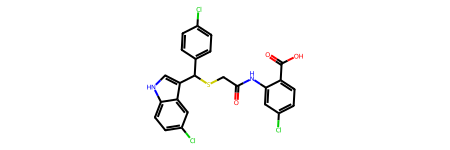

73 CReM 0.3949400886893272


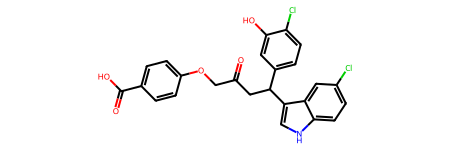

74 CReM 0.3939831100404262


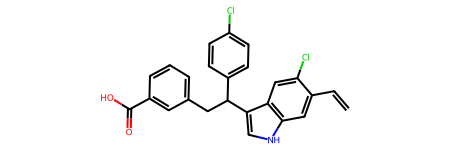

75 CReM 0.3925950616598129


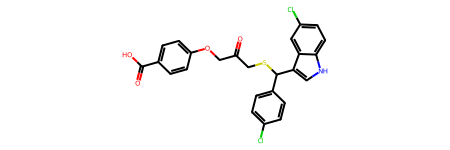

76 CReM 0.3925378732383251


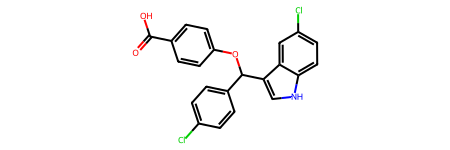

77 CReM 0.3903191439807415


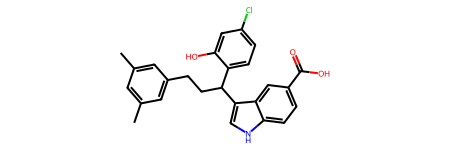

78 CReM 0.3864183343946933


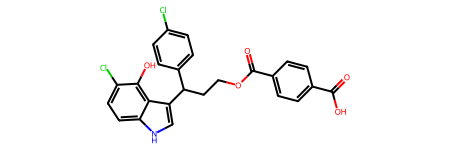

79 CReM 0.3854750856757164
dereplicated: 80


SMILES  ACTIVITY Method   Cpd
0   O=C(O)c1c(F)cc(C(c2ccc(Cl)cc2)c2c[nH]c3ccc(Cl)...  0.558706    VAE  V027
1   CSC(C(=O)CC(c1ccc(Cl)cc1)c1c[nH]c2ccc(Cl)cc12)...  0.551632    VAE  V027
2   CSc1c(C(=O)O)ccc(C(c2ccc(Cl)cc2)c2c[nH]c3ccc(C...  0.535047    VAE  V027
3   O=C(O)c1cc(C(c2ccc(Cl)cc2)c2c[nH]c3ccc(Cl)cc23...  0.534378    VAE  V027
4   O=C(O)C1SCC(=O)N1C(=O)C(c1ccc(Cl)cc1)c1c[nH]c2...  0.534188    VAE  V027
..                                                ...       ...    ...   ...
75  C=Cc1cc2[nH]cc(C(Cc3cccc(C(=O)O)c3)c3ccc(Cl)cc...  0.392595   CReM  V027
76  O=C(COc1ccc(C(=O)O)cc1)CSC(c1ccc(Cl)cc1)c1c[nH...  0.392538   CReM  V027
77  O=C(O)c1ccc(OC(c2ccc(Cl)cc2)c2c[nH]c3ccc(Cl)cc...  0.390319   CReM  V027
78  Cc1cc(C)cc(CCC(c2ccc(Cl)cc2O)c2c[nH]c3ccc(C(=O...  0.386418   CReM  V027
79  O=C(O)c1ccc(C(=O)OCCC(c2ccc(Cl)cc2)c2c[nH]c3cc...  0.385475   CReM  V027

[80 rows x 4 columns]

In [6]:
# downselect for v027 with VAE and CReM compounds
cpd_v027_vae_downselect = select_cpds_from_df(pd.concat([v027_vae,v027mcs_vae]), maximum = 40, top_to_get = 20)
cpd_v027_crem_downselect = select_cpds_from_df(v027_crem, maximum = 40, top_to_get = 20)
df_v027 = pd.concat([cpd_v027_vae_downselect, cpd_v027_crem_downselect])
print('combined crem and vae: ' + str(len(df_v027)))
# hacky to get the unique cpds only
unique_df_v027 = select_cpds_from_df(df_v027, maximum = len(df_v027), top_to_get = 0, max_tan_allowed_after_top = 1.0)
print('dereplicated: ' + str(len(unique_df_v027)))
unique_df_v027.to_csv('../out/crem/v027_crem/DOWNSELECT_PRIORITY_crem_vae_V027_molecules_03_28_2023.csv', index = False)
unique_df_v027

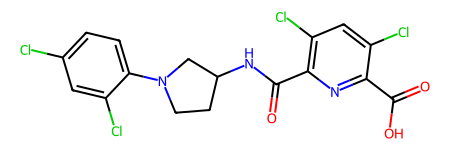

0 VAE 0.89158216714859


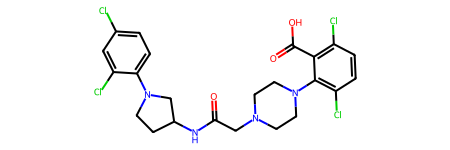

1 VAE 0.873349108695983


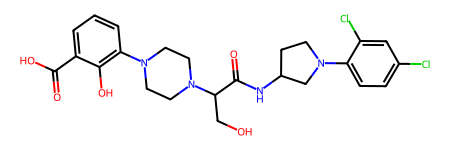

2 VAE 0.867866657972335


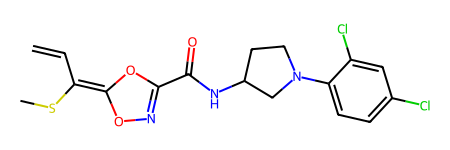

3 VAE 0.864005033373832


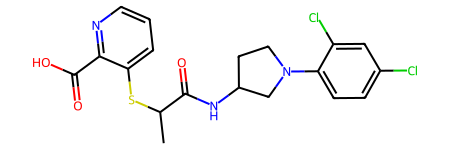

4 VAE 0.863609694242477


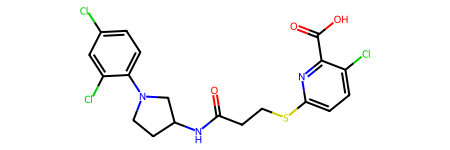

5 VAE 0.860304555892944


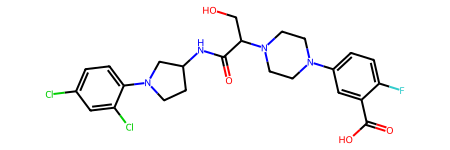

6 VAE 0.859394317865371


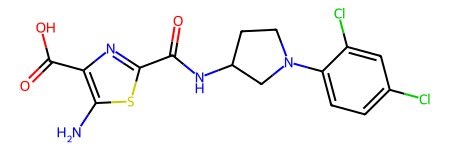

7 VAE 0.858684870004653


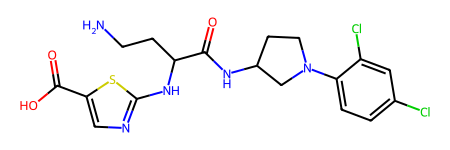

8 VAE 0.858487669229507


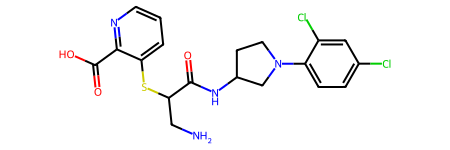

9 VAE 0.853916534185409


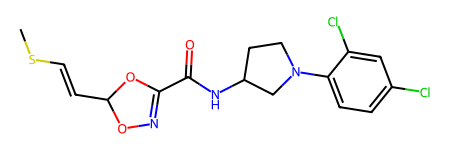

10 VAE 0.853706474304199


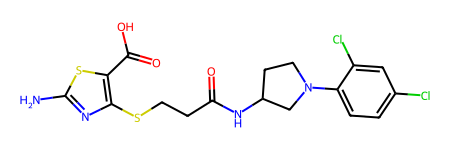

11 VAE 0.853243525028228


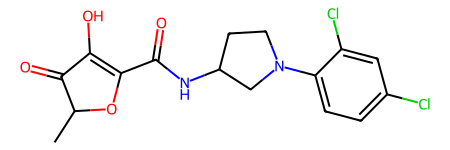

12 VAE 0.853179950714111


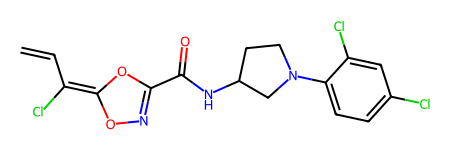

13 VAE 0.852278097271919


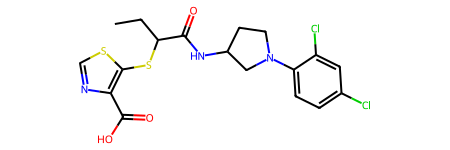

14 VAE 0.851775755286216


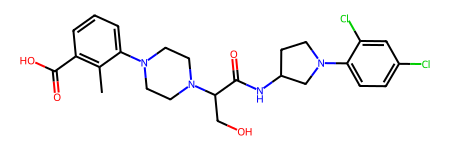

15 VAE 0.851173176765441


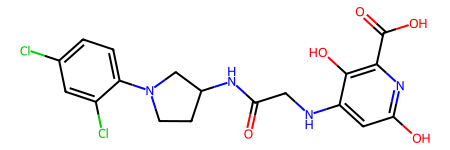

16 VAE 0.850119401216507


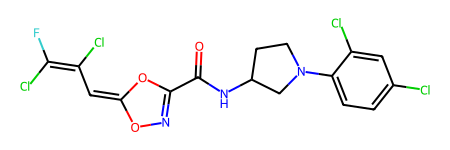

17 VAE 0.849595439434051


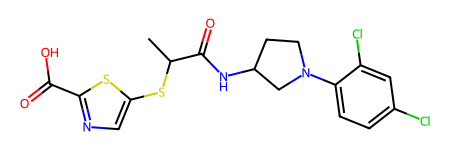

18 VAE 0.848206100463867


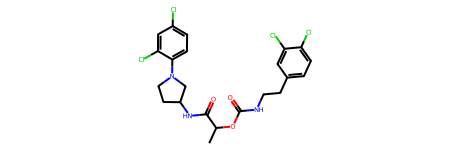

19 VAE 0.848034554719925


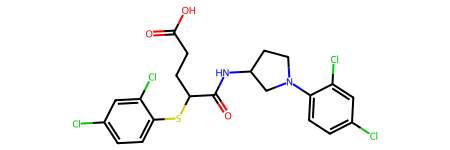

22 VAE 0.845277166366577


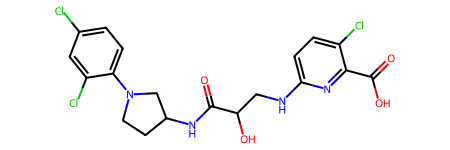

23 VAE 0.844789713621139


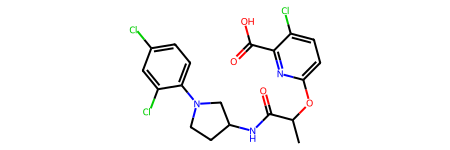

24 VAE 0.843756581544876


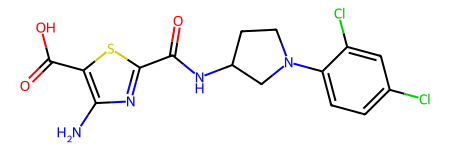

28 VAE 0.841828941702842


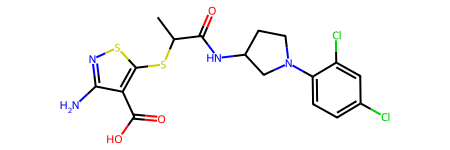

31 VAE 0.839508809447288


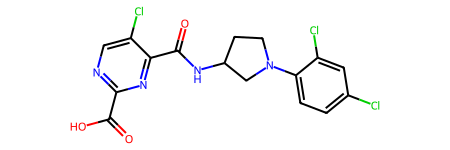

32 VAE 0.838872030973434


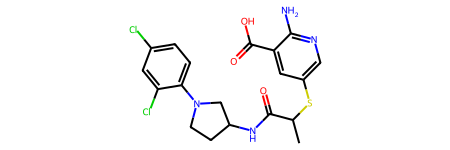

35 VAE 0.837087601423263


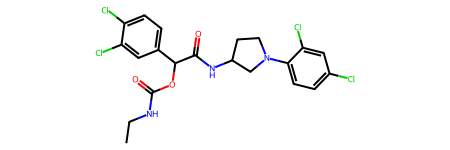

36 VAE 0.837060745358467


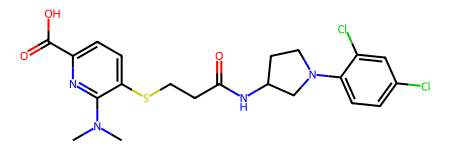

37 VAE 0.83688290476799


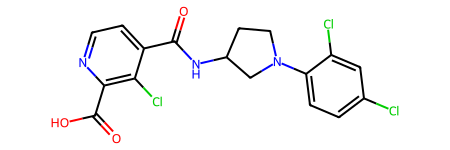

38 VAE 0.836851332187652


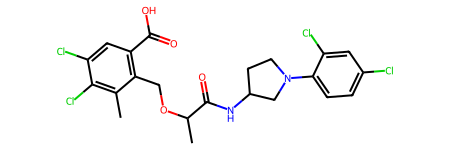

41 VAE 0.835907819271087


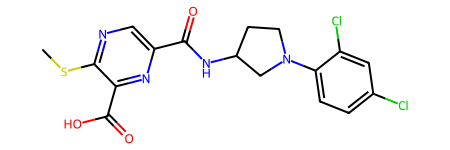

43 VAE 0.834735082387924


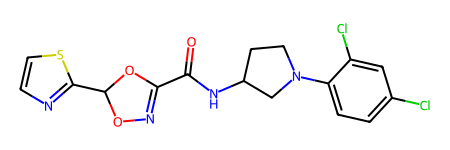

44 VAE 0.833631184101104


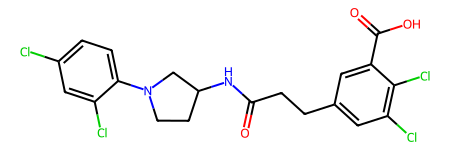

45 VAE 0.833600153923034


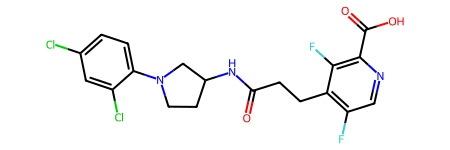

46 VAE 0.833199821710586


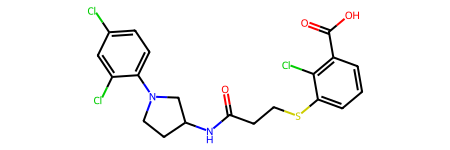

48 VAE 0.832718213796615


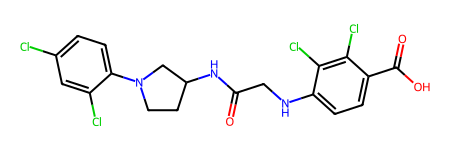

50 VAE 0.829994843006134


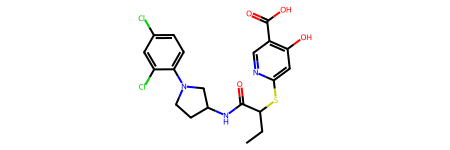

53 VAE 0.826534729003906


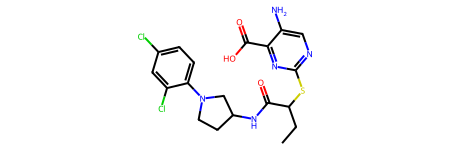

54 VAE 0.826335071027278


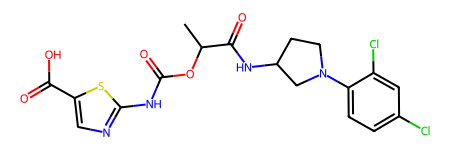

57 VAE 0.824957444667816
*********REACHED END: SELECTED 40 MOLECULES*********


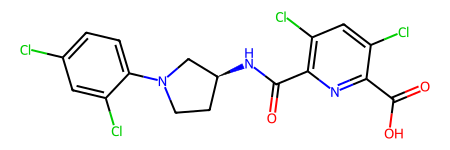

0 CReM 0.8897165668010711


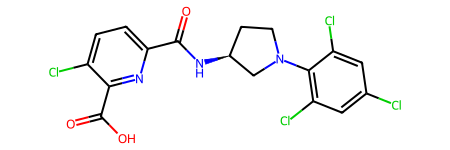

1 CReM 0.8754190623760223


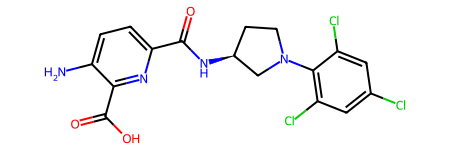

2 CReM 0.8682587289810181


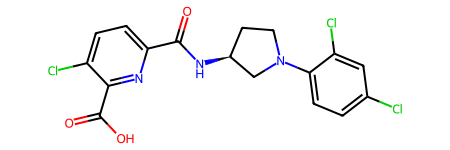

3 CReM 0.8526439273357391


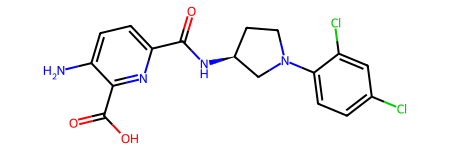

4 CReM 0.8362515807151795


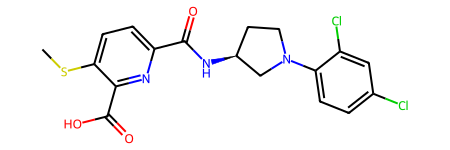

5 CReM 0.8328937399387359


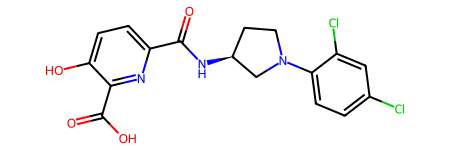

6 CReM 0.8180875885486603


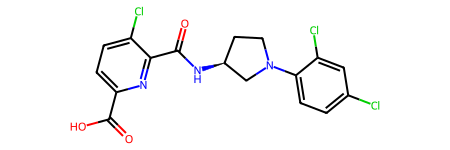

7 CReM 0.8174192178249359


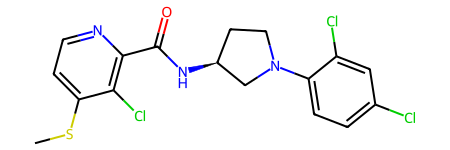

8 CReM 0.8153913879394531


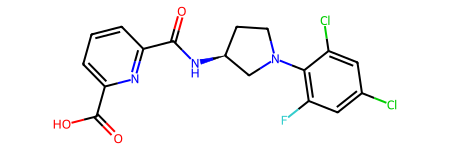

9 CReM 0.8136078661680222


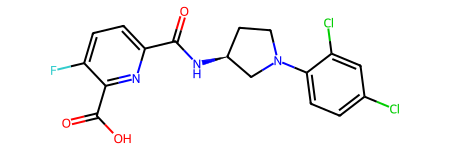

10 CReM 0.8109516561031341


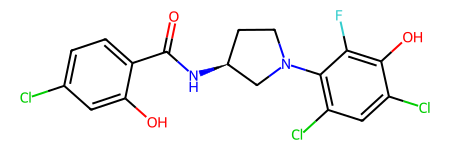

11 CReM 0.8105654180049896


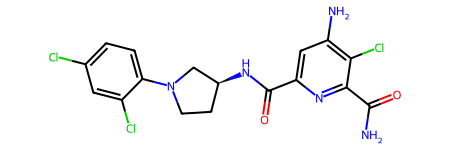

12 CReM 0.8102345454692841


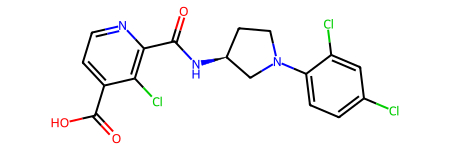

13 CReM 0.809871951341629


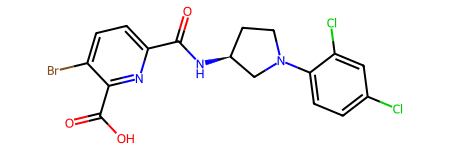

14 CReM 0.8092261099815369


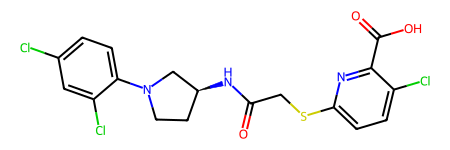

15 CReM 0.8077055662870407


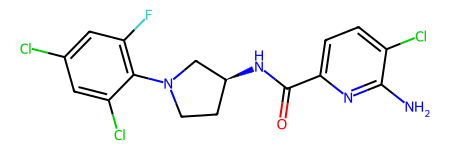

16 CReM 0.8075491690635681


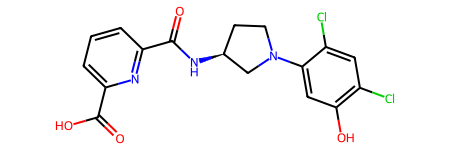

17 CReM 0.8073299300670623


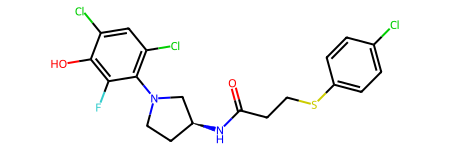

18 CReM 0.8070236134529114


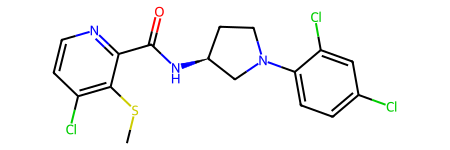

19 CReM 0.8067362928390502


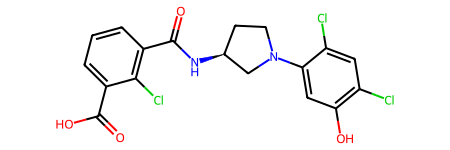

21 CReM 0.8011186826229095


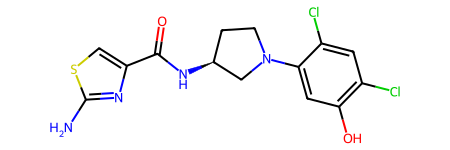

25 CReM 0.7985840284824371


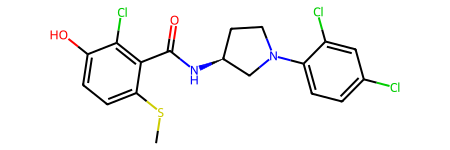

65 CReM 0.7727965795993805


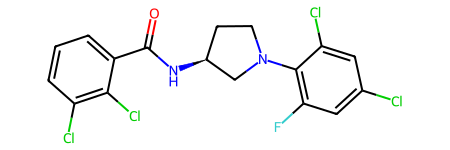

74 CReM 0.7697908854484559


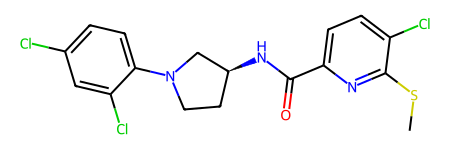

83 CReM 0.7637501120567322


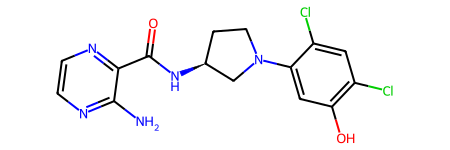

86 CReM 0.7613846546411515


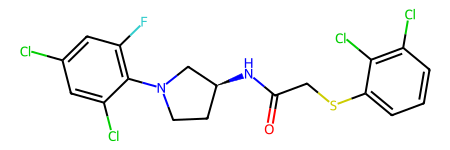

87 CReM 0.7603137952089309


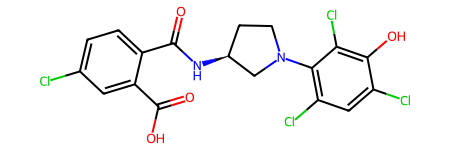

94 CReM 0.7565830880403519


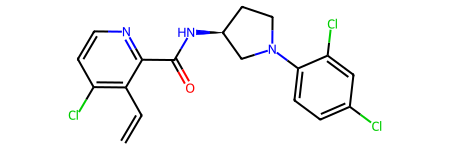

112 CReM 0.7508719801902771


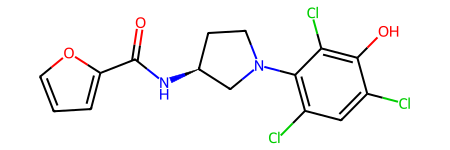

118 CReM 0.7478840231895447


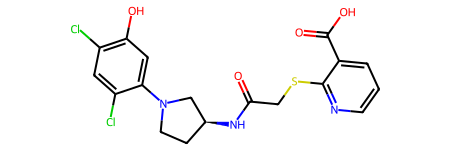

126 CReM 0.7460426199436188


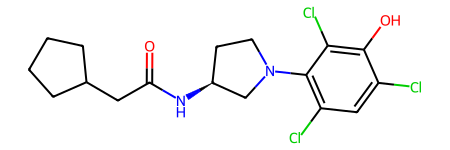

141 CReM 0.7381018847227097


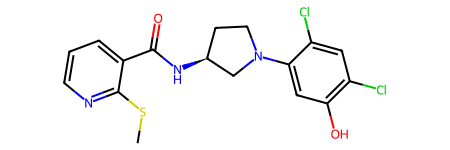

164 CReM 0.7293010294437409


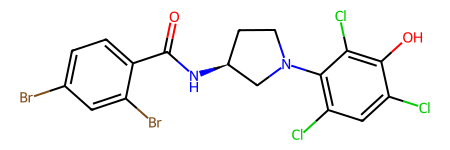

167 CReM 0.7269867467880249


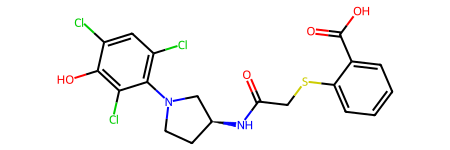

171 CReM 0.7261288732290268


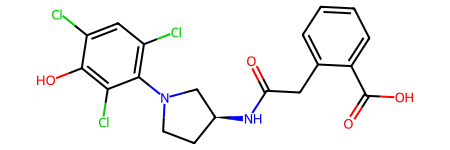

174 CReM 0.725745941400528


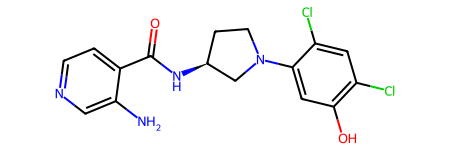

192 CReM 0.7191322410106659


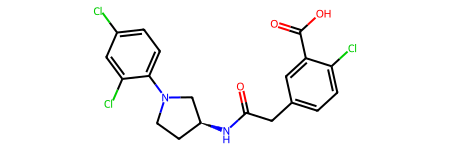

197 CReM 0.7166227543354035


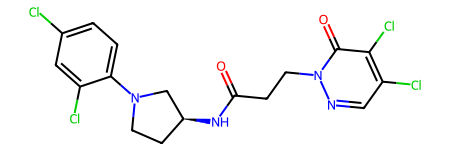

198 CReM 0.7166213411092758


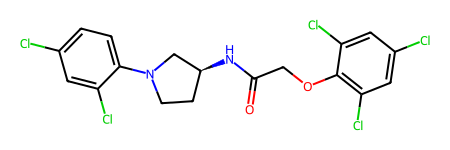

217 CReM 0.712654463648796
*********REACHED END: SELECTED 40 MOLECULES*********
combined crem and vae: 80


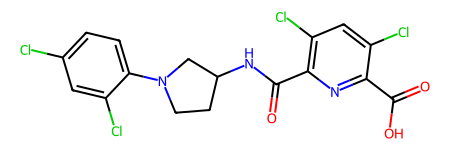

0 VAE 0.89158216714859


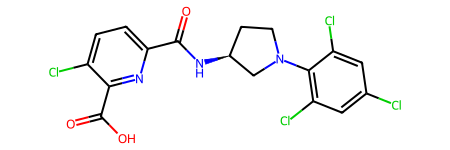

2 CReM 0.8754190623760223


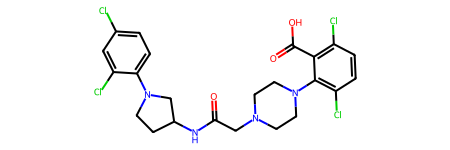

3 VAE 0.873349108695983


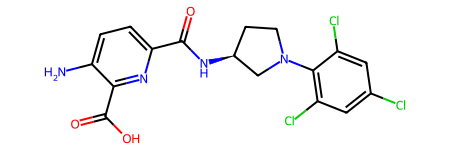

4 CReM 0.8682587289810181


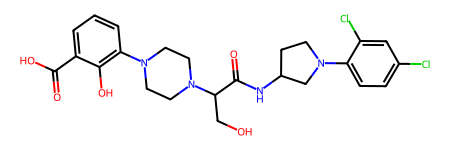

5 VAE 0.867866657972335


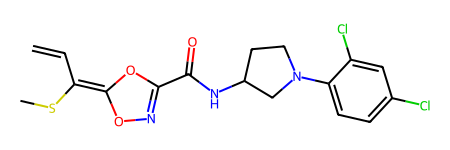

6 VAE 0.864005033373832


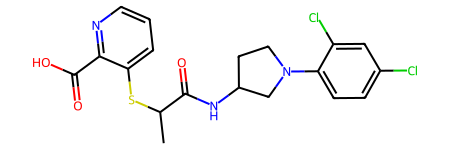

7 VAE 0.863609694242477


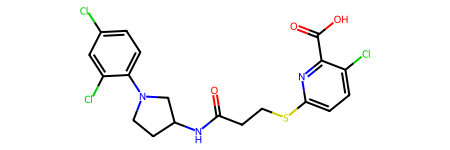

8 VAE 0.860304555892944


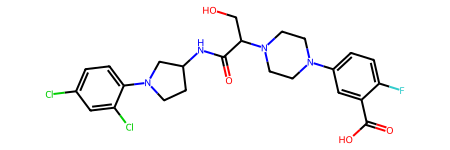

9 VAE 0.859394317865371


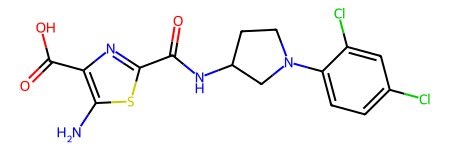

10 VAE 0.858684870004653


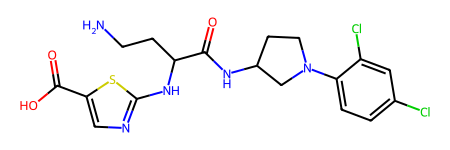

11 VAE 0.858487669229507


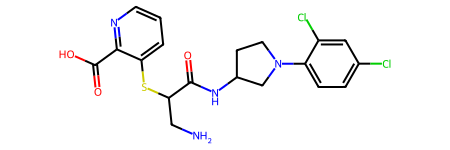

12 VAE 0.853916534185409


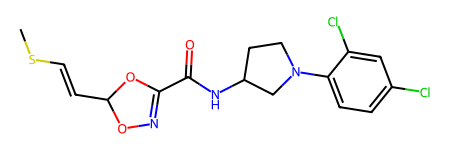

13 VAE 0.853706474304199


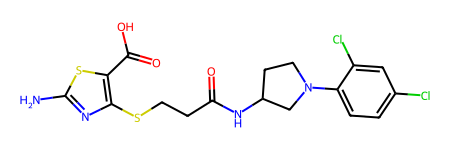

14 VAE 0.853243525028228


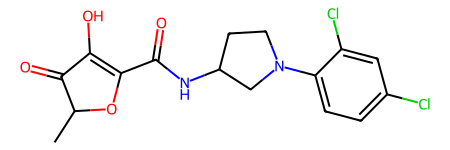

15 VAE 0.853179950714111


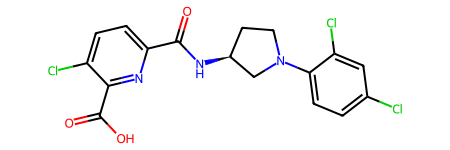

16 CReM 0.8526439273357391


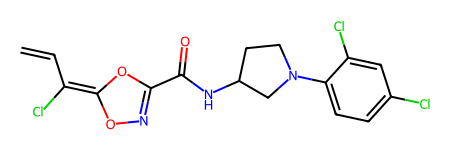

17 VAE 0.852278097271919


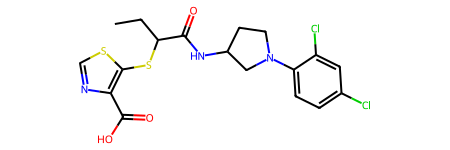

18 VAE 0.851775755286216


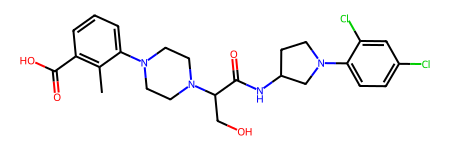

19 VAE 0.851173176765441


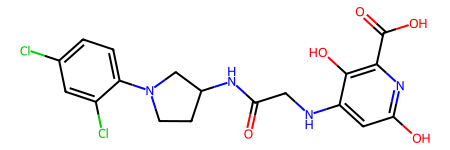

20 VAE 0.850119401216507


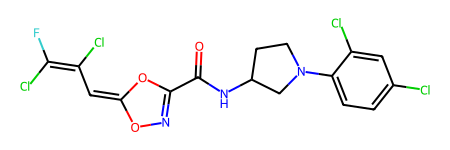

21 VAE 0.849595439434051


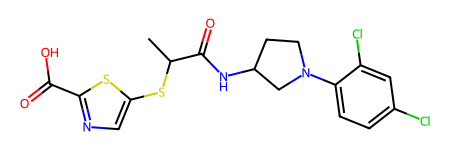

22 VAE 0.848206100463867


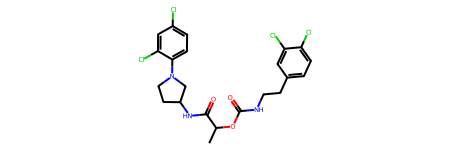

23 VAE 0.848034554719925


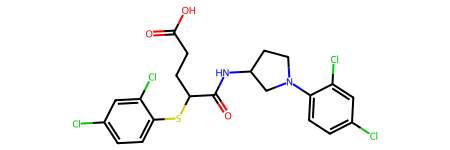

24 VAE 0.845277166366577


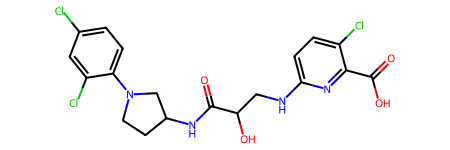

25 VAE 0.844789713621139


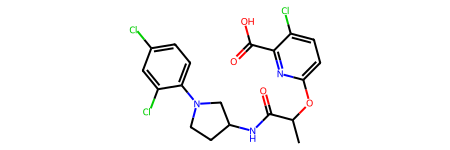

26 VAE 0.843756581544876


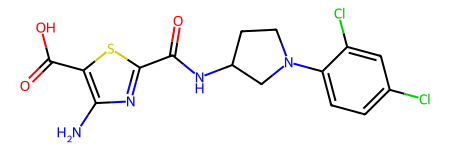

27 VAE 0.841828941702842


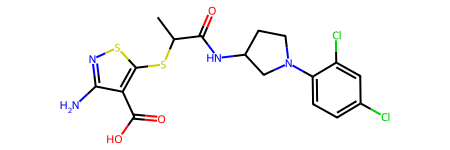

28 VAE 0.839508809447288


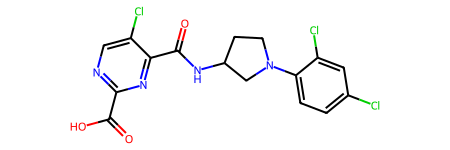

29 VAE 0.838872030973434


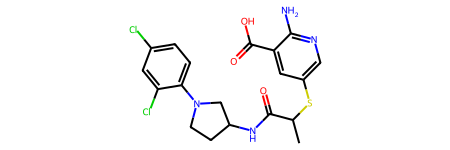

30 VAE 0.837087601423263


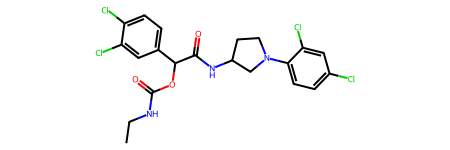

31 VAE 0.837060745358467


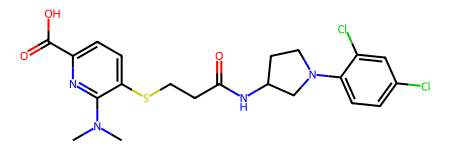

32 VAE 0.83688290476799


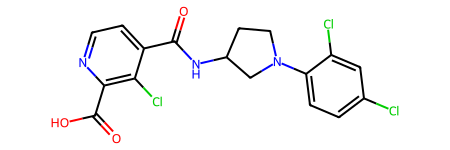

33 VAE 0.836851332187652


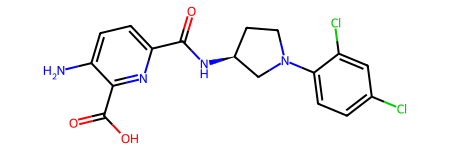

34 CReM 0.8362515807151795


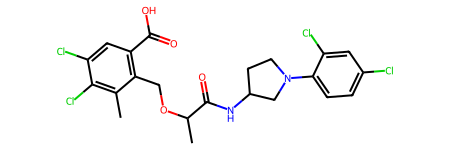

35 VAE 0.835907819271087


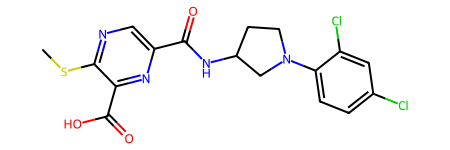

36 VAE 0.834735082387924


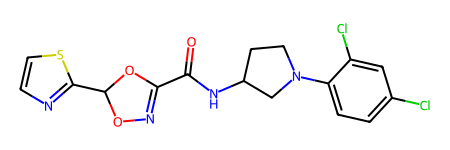

37 VAE 0.833631184101104


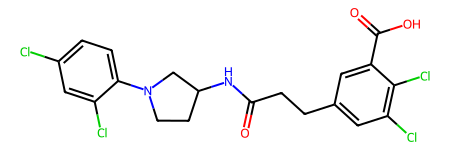

38 VAE 0.833600153923034


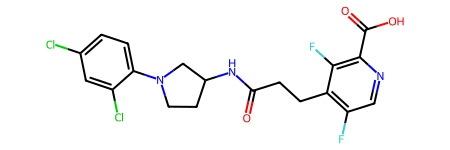

39 VAE 0.833199821710586


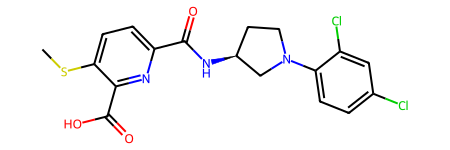

40 CReM 0.8328937399387359


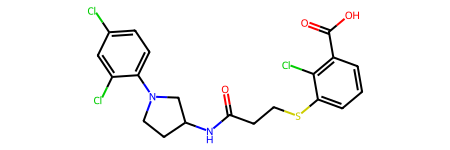

41 VAE 0.832718213796615


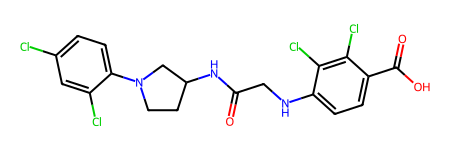

42 VAE 0.829994843006134


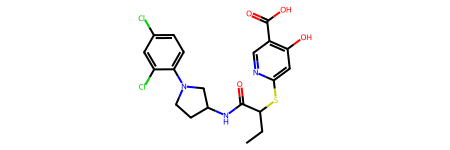

43 VAE 0.826534729003906


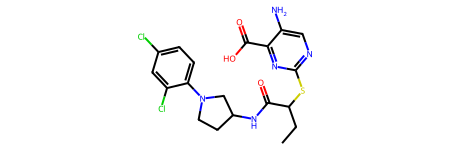

44 VAE 0.826335071027278


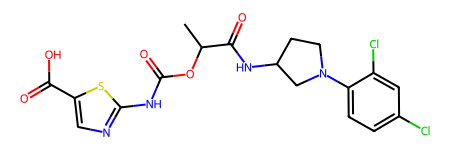

45 VAE 0.824957444667816


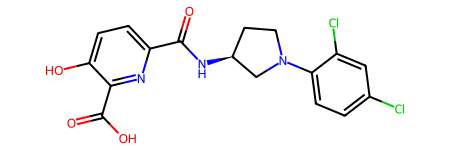

46 CReM 0.8180875885486603


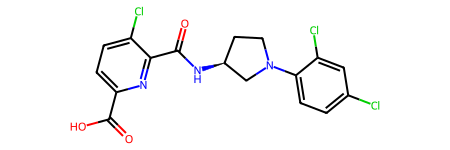

47 CReM 0.8174192178249359


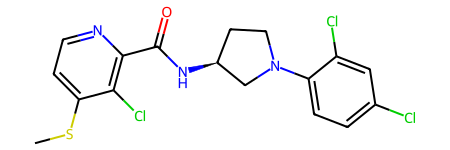

48 CReM 0.8153913879394531


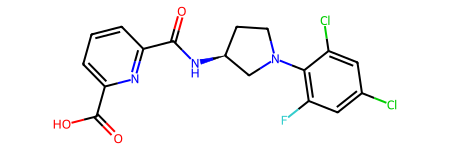

49 CReM 0.8136078661680222


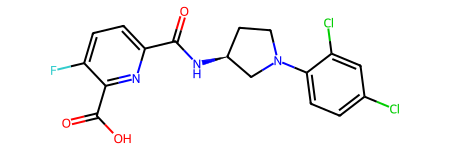

50 CReM 0.8109516561031341


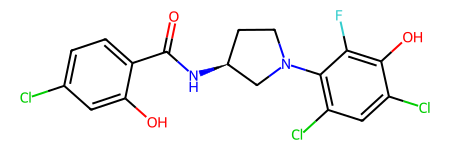

51 CReM 0.8105654180049896


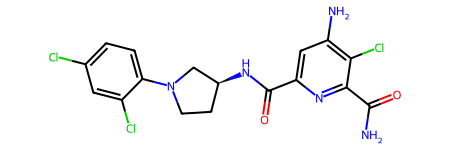

52 CReM 0.8102345454692841


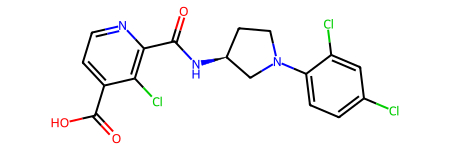

53 CReM 0.809871951341629


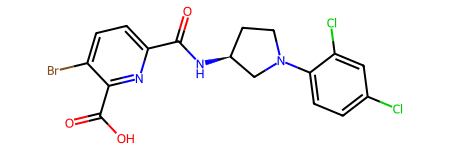

54 CReM 0.8092261099815369


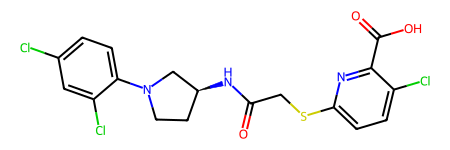

55 CReM 0.8077055662870407


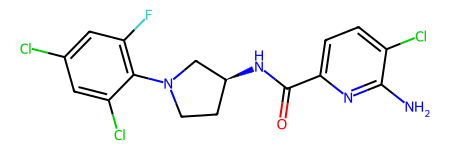

56 CReM 0.8075491690635681


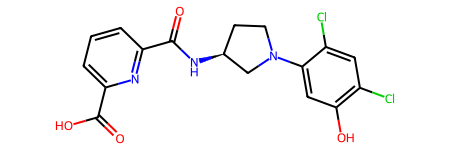

57 CReM 0.8073299300670623


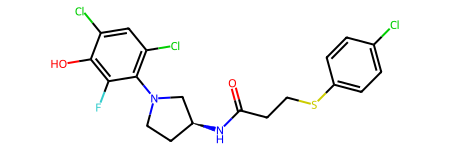

58 CReM 0.8070236134529114


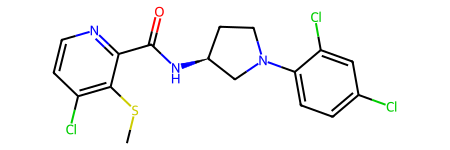

59 CReM 0.8067362928390502


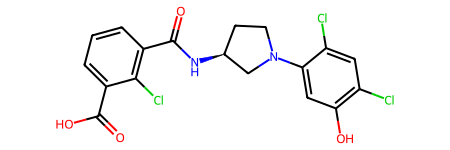

60 CReM 0.8011186826229095


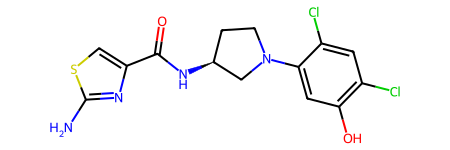

61 CReM 0.7985840284824371


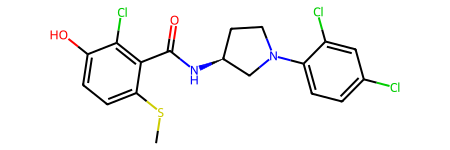

62 CReM 0.7727965795993805


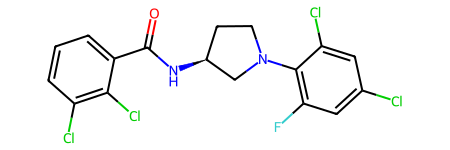

63 CReM 0.7697908854484559


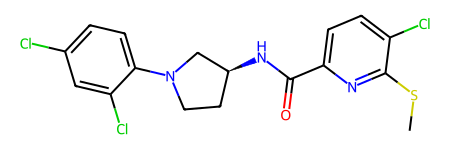

64 CReM 0.7637501120567322


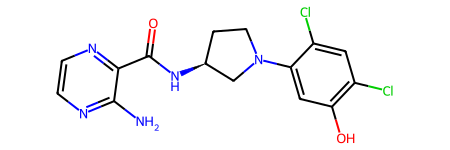

65 CReM 0.7613846546411515


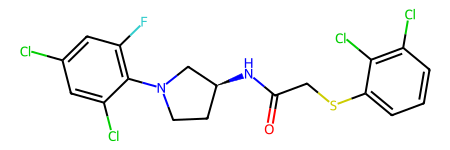

66 CReM 0.7603137952089309


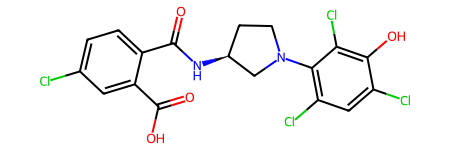

67 CReM 0.7565830880403519


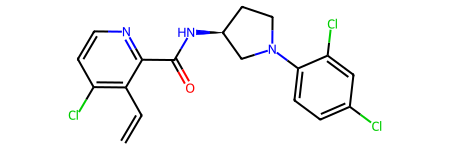

68 CReM 0.7508719801902771


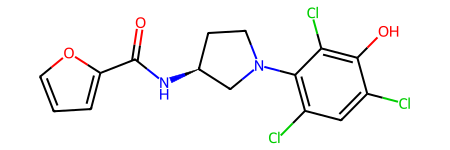

69 CReM 0.7478840231895447


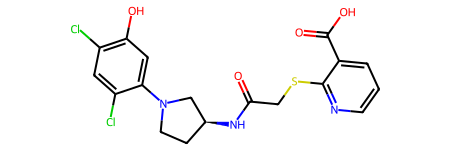

70 CReM 0.7460426199436188


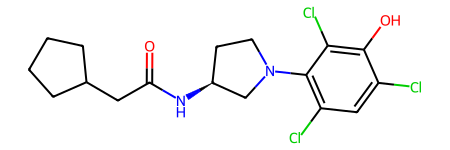

71 CReM 0.7381018847227097


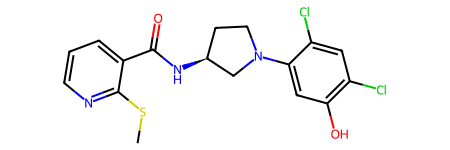

72 CReM 0.7293010294437409


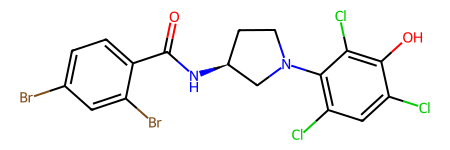

73 CReM 0.7269867467880249


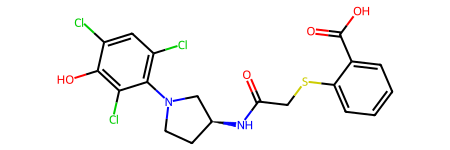

74 CReM 0.7261288732290268


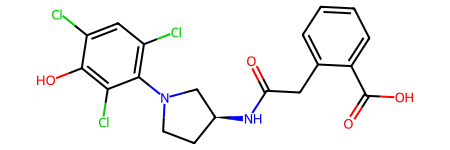

75 CReM 0.725745941400528


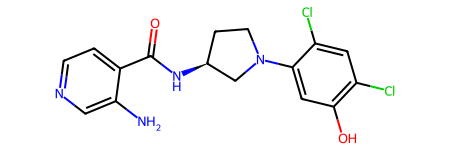

76 CReM 0.7191322410106659


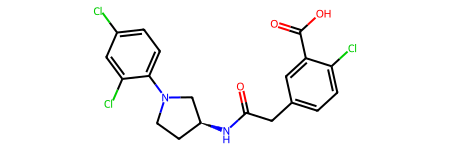

77 CReM 0.7166227543354035


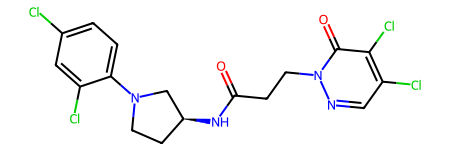

78 CReM 0.7166213411092758


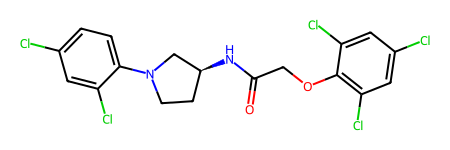

79 CReM 0.712654463648796
dereplicated: 79


SMILES  ACTIVITY Method     Cpd
0   O=C(O)c1nc(C(=O)NC2CCN(c3ccc(Cl)cc3Cl)C2)c(Cl)...  0.891582    VAE  NG_Cpd
2   O=C(N[C@H]1CCN(c2c(Cl)cc(Cl)cc2Cl)C1)c1ccc(Cl)...  0.875419   CReM  NG_Cpd
3   O=C(CN1CCN(c2c(Cl)ccc(Cl)c2C(=O)O)CC1)NC1CCN(c...  0.873349    VAE  NG_Cpd
4   Nc1ccc(C(=O)N[C@H]2CCN(c3c(Cl)cc(Cl)cc3Cl)C2)n...  0.868259   CReM  NG_Cpd
5   O=C(O)c1cccc(N2CCN(C(CO)C(=O)NC3CCN(c4ccc(Cl)c...  0.867867    VAE  NG_Cpd
..                                                ...       ...    ...     ...
75  O=C(Cc1ccccc1C(=O)O)N[C@H]1CCN(c2c(Cl)cc(Cl)c(...  0.725746   CReM  NG_Cpd
76      Nc1cnccc1C(=O)N[C@H]1CCN(c2cc(O)c(Cl)cc2Cl)C1  0.719132   CReM  NG_Cpd
77  O=C(Cc1ccc(Cl)c(C(=O)O)c1)N[C@H]1CCN(c2ccc(Cl)...  0.716623   CReM  NG_Cpd
78  O=C(CCn1ncc(Cl)c(Cl)c1=O)N[C@H]1CCN(c2ccc(Cl)c...  0.716621   CReM  NG_Cpd
79  O=C(COc1c(Cl)cc(Cl)cc1Cl)N[C@H]1CCN(c2ccc(Cl)c...  0.712654   CReM  NG_Cpd

[79 rows x 4 columns]

In [7]:
# downselect for NG cpd with VAE and CReM compounds
ng_vae_downselect = select_cpds_from_df(ng_vae, maximum = 40, top_to_get = 20)
ng_crem_downselect = select_cpds_from_df(ng_crem, maximum = 40, top_to_get = 20)
df_ng = pd.concat([ng_crem_downselect, ng_vae_downselect])
print('combined crem and vae: ' + str(len(df_ng)))
# hacky to get the unique cpds only
unique_ng_df = select_cpds_from_df(df_ng, maximum = 80, top_to_get = 0, max_tan_allowed_after_top = 1.0)
print('dereplicated: ' + str(len(unique_ng_df)))
unique_ng_df.to_csv('../out/crem/ng_crem/DOWNSELECT_PRIORITY_crem_vae_ng_molecules_03_28_2023.csv', index = False)
unique_ng_df